In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader,TensorDataset

# 生成示例多参数时间序列数据
# 加载数据
df = pd.read_csv(
    r"C:\Users\AIO\Desktop\Walmart.csv", parse_dates=["Date"], index_col="Date"
)
df = df[
    ["Weekly_Sales", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
]

# 数据预处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


# 创建训练数据集
def create_dataset(data, label_col, step=1, additional=0):
    data = data
    data_copy = data.copy()
    data_copy[:, label_col] = 0
    T, col_nums = data.shape
    features = np.zeros((step + additional, T - step - additional, col_nums))
    for i in range(step + additional):
        if i < step:
            features[i, :, :] = data[i : T - step - additional + i, :]
        else:
            features[i, :, :] = data_copy[i : T - step - additional + i, :]
    labels = data[step : T - additional, [label_col]].reshape((-1, 1))
    return features.transpose(1, 0, 2), labels


time_step = 10
additional = 5
X, y = create_dataset(scaled_data, 0, time_step, additional)

print(X.shape, y.shape)


class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


print("X.shape:", X.shape)
dataset = TimeSeriesDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=15000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[: x.size(0), :]

(6420, 15, 6) (6420, 1)
X.shape: (6420, 15, 6)


In [2]:
X.shape,y.shape

((6420, 15, 6), (6420, 1))

In [18]:
# 定义时间序列预测模型
class MultivariateTimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        num_heads,
        hidden_size,
        num_layers,
        dim_feedforward,
        n_step,
        dropout=0.1,
    ):
        super().__init__()
        self.positional_encoding = PositionalEncoding(input_size)
        self.pre_fc1 = nn.Linear(input_size, dim_feedforward)
        # self.pre_fc2 = nn.Linear(dim_feedforward, input_size)
        self.attn = nn.MultiheadAttention(
            input_size, num_heads, dropout=dropout, batch_first=True
        )
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.faltten = nn.Flatten()
        self.out_fc1 = nn.Linear(180, 64)
        self.out_fc2 = nn.Linear(64, 1)

    def forward(self, x):
        hidden = None
        x = self.positional_encoding(x)
        x = self.pre_fc1(x)
        # print('pre_fc1(x).shape',x.shape)
        x = self.pre_fc2(x)
        # print('pre_fc2(x).shape',x.shape)
        x, _ = self.attn(x, x, x)
        # print('attn(x).shape',x.shape)
        x, hidden = self.lstm(x, hidden)
        # print('lstm(x).shape',x.shape)
        x = self.faltten(x)
        # print('faltten(x).shape',x.shape)
        x = self.out_fc1(x)
        # print('out_fc1(x).shape',x.shape)
        x = self.out_fc2(x)
        # print('out_fc2(x).shape',x.shape)
        return x

In [19]:
# 模型初始化
input_size = 6
num_heads = 2
hidden_size= 6
n_step=15
num_layers = 6
dim_feedforward = 256

dropout = 0.1

model = MultivariateTimeSeriesTransformer(
    input_size, num_heads, hidden_size, num_layers, dim_feedforward,n_step, dropout
)

In [20]:
for node in model.named_children():
    print(node)

('positional_encoding', PositionalEncoding())
('pre_fc1', Linear(in_features=6, out_features=256, bias=True))
('attn', MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
))
('lstm', LSTM(6, 6, num_layers=6, batch_first=True, bidirectional=True))
('faltten', Flatten(start_dim=1, end_dim=-1))
('out_fc1', Linear(in_features=180, out_features=64, bias=True))
('out_fc2', Linear(in_features=64, out_features=1, bias=True))


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
for x1,y1 in train_loader:
    print(x1.shape,y1.shape)
    break

torch.Size([32, 15, 6]) torch.Size([32, 1])


In [24]:
# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        # x_batch = x_batch.view(-1, time_step, input_size)
        # y_batch = y_batch.view(-1, 1)
        outputs = model(x_batch)
        # print('x_batch.shape,y_batch.shape,outputs.shape')
        # print(x_batch.shape,y_batch.shape,outputs.shape)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 2== 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

AttributeError: 'MultivariateTimeSeriesTransformer' object has no attribute 'pre_fc2'

(6420,) (6420, 1)


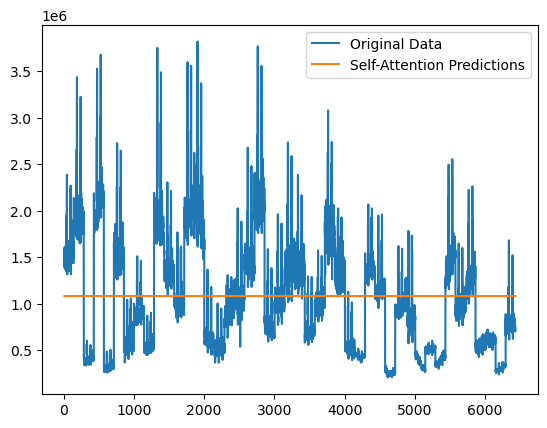

In [17]:
# 预测
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32)
    predictions = model(X_tensor).cpu().numpy()
    
predictions = scaler.inverse_transform(np.column_stack((predictions, np.zeros((len(predictions), 5)))))[:,0]
print(predictions.shape,y.shape)
# # 可视化结果
plt.plot(np.arange(time_step, len(predictions) + time_step),df[time_step: len(predictions) + time_step]['Weekly_Sales'],label='Original Data')
plt.plot(
    np.arange(time_step, len(predictions) + time_step),
    predictions,
    label="Self-Attention Predictions"
)
plt.legend()
plt.show()

In [10]:
df[time_step: len(predictions) + time_step]['Weekly_Sales']


Date
16-04-2010    1466058.28
23-04-2010    1391256.12
30-04-2010    1425100.71
07-05-2010    1603955.12
14-05-2010    1494251.50
                 ...    
24-08-2012     718232.26
31-08-2012     734297.87
07-09-2012     766512.66
14-09-2012     702238.27
21-09-2012     723086.20
Name: Weekly_Sales, Length: 6420, dtype: float64

In [11]:
y.shape,predictions.shape

((6420, 1), (6420, 1))

In [12]:
predictions

array([[-0.02664799],
       [-0.02669212],
       [-0.02674077],
       ...,
       [-0.02680262],
       [-0.02681417],
       [-0.0267976 ]], dtype=float32)

In [13]:
df['Weekly_Sales']

Date
05-02-2010    1643690.90
12-02-2010    1641957.44
19-02-2010    1611968.17
26-02-2010    1409727.59
05-03-2010    1554806.68
                 ...    
28-09-2012     713173.95
05-10-2012     733455.07
12-10-2012     734464.36
19-10-2012     718125.53
26-10-2012     760281.43
Name: Weekly_Sales, Length: 6435, dtype: float64